In [17]:
from prophet import Prophet
import yfinance as yf

import matplotlib.pyplot as plt
import plotly
import pandas as pd
from pandas import Series
import numpy
from math import sqrt

from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np

[*********************100%%**********************]  1 of 1 completed

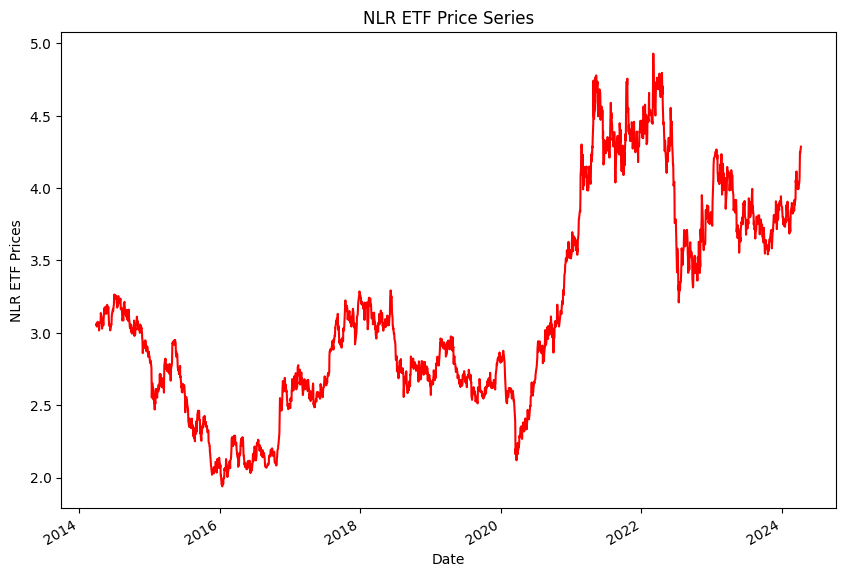

In [4]:
raw_df = yf.download('HG=F', '2014-04-01', '2024-04-10')
raw_df = raw_df[['Close']]

# reconfigure with Date column
df = raw_df
# df = raw_df.copy()
# df.reset_index(inplace=True)
# df.rename(columns={'Date': 'Date'}, inplace=True)

# only keep closing price
df = df.dropna()
df.Close.plot(figsize=(10, 7),color='r')
plt.ylabel("NLR ETF Prices")
plt.title("NLR ETF Price Series")
plt.show()

supervised ds: 
            Close(t-1)  Close(t-%d)
Date                               
2014-04-02      3.0550       3.0650
2014-04-03      3.0650       3.0470
2014-04-04      3.0470       3.0430
2014-04-07      3.0430       3.0635
2014-04-08      3.0635       3.0765
...                ...          ...
2024-04-03      4.0700       4.1930
2024-04-04      4.1930       4.2465
2024-04-05      4.2465       4.2395
2024-04-08      4.2395       4.2770
2024-04-09      4.2770       4.2860

[2520 rows x 2 columns]
scaled: 
[[0.37313936 0.3764844 ]
 [0.3764844  0.37046328]
 [0.37046328 0.36912528]
 ...
 [0.77170099 0.76935947]
 [0.76935947 0.78190334]
 [0.78190334 0.78491382]]
Epoch 1/200


c:\Users\jyin1\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 - 1s - 109ms/step - loss: 0.1536 - val_loss: 0.3527
Epoch 2/200
12/12 - 0s - 6ms/step - loss: 0.1181 - val_loss: 0.2839
Epoch 3/200
12/12 - 0s - 6ms/step - loss: 0.0903 - val_loss: 0.2247
Epoch 4/200
12/12 - 0s - 6ms/step - loss: 0.0683 - val_loss: 0.1742
Epoch 5/200
12/12 - 0s - 5ms/step - loss: 0.0519 - val_loss: 0.1325
Epoch 6/200
12/12 - 0s - 9ms/step - loss: 0.0405 - val_loss: 0.0997
Epoch 7/200
12/12 - 0s - 7ms/step - loss: 0.0336 - val_loss: 0.0754
Epoch 8/200
12/12 - 0s - 6ms/step - loss: 0.0300 - val_loss: 0.0584
Epoch 9/200
12/12 - 0s - 6ms/step - loss: 0.0282 - val_loss: 0.0472
Epoch 10/200
12/12 - 0s - 6ms/step - loss: 0.0273 - val_loss: 0.0400
Epoch 11/200
12/12 - 0s - 6ms/step - loss: 0.0265 - val_loss: 0.0354
Epoch 12/200
12/12 - 0s - 6ms/step - loss: 0.0256 - val_loss: 0.0323
Epoch 13/200
12/12 - 0s - 6ms/step - loss: 0.0247 - val_loss: 0.0300
Epoch 14/200
12/12 - 0s - 6ms/step - loss: 0.0236 - val_loss: 0.0282
Epoch 15/200
12/12 - 0s - 6ms/step - loss: 0.0225 - v

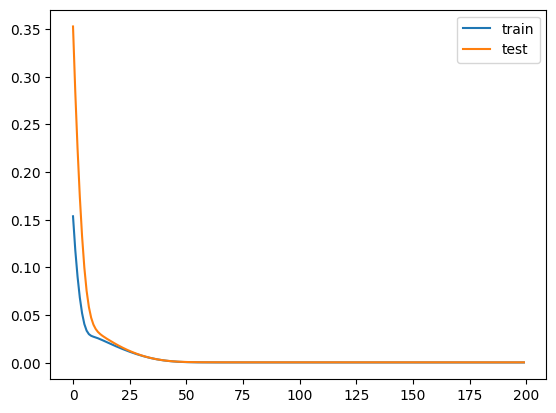

In [14]:
# machine learning with LSTM model
num_features = 1
lag_steps = 1
label_feature = 'Close'

def sequential_to_supervised(df, lag_steps = 1, n_out = 1, dropnan = True):
    features = 1 #if type(data) is list else data.shape[1] # Get the number of features in dataset
    cols = list()
    feature_names = list()

    for i in range(lag_steps, 0, -1):
        cols.append(df.shift(i)) # This will be the shifted dataset
        feature_names += [(str(df.columns[j])) + '(t-%d)' % (i) for j in range(features)] # Names of the shifted features

    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            feature_names += [(str(df.columns[j])) + '(t-%d)' for j in range(features)] # Names of the shifted features
        else:
            feature_names += [(str(df.columns[j])) + '(t-%d)' % (i) for j in range(features)] # Names of the shifted features

    agg = concat(cols, axis=1)
    agg.columns = feature_names

    if dropnan:
        agg.dropna(inplace=True)
    return agg

supervised_dataset = sequential_to_supervised(df, lag_steps)

print("supervised ds: ")
print(supervised_dataset)

# Move label column to the end of dataset
cols_at_end = [label_feature + '(t)']
supervised_dataset = supervised_dataset[[c for c in supervised_dataset if c not in cols_at_end] + [c for c in cols_at_end if c in supervised_dataset]]

# Dropping the current timestep columns of features other than the one being predicted, which will be the label or y
supervised_dataset.drop(supervised_dataset.columns[(num_features*lag_steps) : (num_features*lag_steps + num_features -1)], axis=1, inplace=True)

#print(supervised_dataset.shape) # Used for debugging
scaler = MinMaxScaler(feature_range=(0, 1))
supervised_dataset_scaled = scaler.fit_transform(supervised_dataset) # Scaling all values

print("scaled: ")
print(supervised_dataset_scaled)

# sets for training and testing
split = int(supervised_dataset_scaled.shape[0]*0.8) # Splitting for traning and testing
train = supervised_dataset_scaled[:split, :]
test = supervised_dataset_scaled[split:, :]

train_X, train_y = train[:, :-1], train[:, -1] # The label column is separated out
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1])) # Reshaping done for LSTM as it needs 3D input
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# Defining the LSTM model to be fit
model = Sequential()
model.add(LSTM(85, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Fitting the model
history = model.fit(train_X, train_y, epochs=200, batch_size=175, validation_data=(test_X, test_y), verbose=2, shuffle=False)
print("history: ", history)
# Plotting the training progression
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[[[0.93460448]]

 [[0.92172613]]

 [[0.9300886 ]]

 [[0.89948154]]

 [[0.92473661]]

 [[0.92574005]]

 [[0.92908517]]

 [[0.95551099]]

 [[0.92808173]]

 [[0.9065061 ]]

 [[0.92456929]]

 [[0.88409435]]

 [[0.83943802]]

 [[0.83642754]]

 [[0.8412779 ]]

 [[0.82756311]]

 [[0.82137483]]

 [[0.77471146]]

 [[0.7798963 ]]

 [[0.79913025]]

 [[0.78457934]]

 [[0.7767185 ]]

 [[0.75380496]]

 [[0.74092661]]

 [[0.76032787]]

 [[0.72436866]]

 [[0.74962372]]

 [[0.75497572]]

 [[0.76935947]]

 [[0.75012552]]

 [[0.78457934]]

 [[0.78324142]]

 [[0.80548584]]

 [[0.79812681]]

 [[0.78190334]]

 [[0.7745443 ]]

 [[0.79093493]]

 [[0.78792446]]

 [[0.79963205]]

 [[0.87456096]]

 [[0.84897142]]

 [[0.83626022]]

 [[0.83626022]]

 [[0.84261582]]

 [[0.8193678 ]]

 [[0.78993149]]

 [[0.76166579]]

 [[0.74326812]]

 [[0.74527516]]

 [[0.72671017]]

 [[0.69509952]]

 [[0.70362947]]

 [[0.67302225]]

 [[0.60846301]]

 [[0.60896473]]

 [[0.61532033]]

 [[0.6169

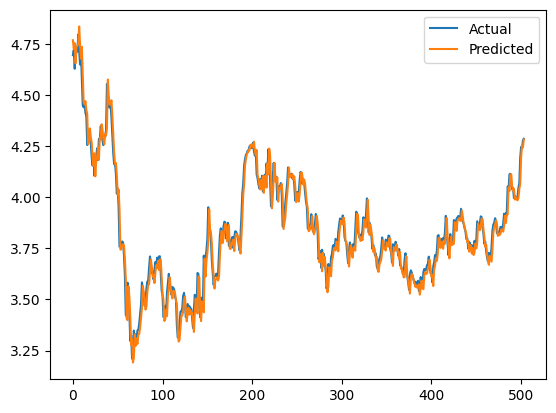

In [10]:
# Using the trained model to predict the label values in test dataset
yhat = model.predict(test_X)
print(test_X)

# Reshaping back into 2D for inversing the scaling
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Concatenating the predict label column with Test data input features, needed for inversing the scaling
inv_yhat = concatenate((test_X[:, 0:], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat) # Rescaling back

inv_yhat = inv_yhat[:, num_features*lag_steps] # Extracting the rescaled predicted label column

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, 0:], test_y), axis=1) # Rejoing the test dataset for inversing the scaling
inv_y = scaler.inverse_transform(inv_y) # Rescaling the actual label column values
inv_y = inv_y[:, num_features*lag_steps] # Extracting the rescaled actual label column

rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat)) # Calculating RMSE
print('Test RMSE: %.3f' % rmse)

pyplot.plot(inv_y, label = 'Actual')
pyplot.plot(inv_yhat, label = 'Predicted')
pyplot.legend()
pyplot.show()

In [ ]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
    
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]
    
# load dataset
df = yf.download('HG=F', '2014-04-01', '2024-04-10')
df = df[['Close']]
df = df.dropna()

# transform data to be supervised learning
supervised = timeseries_to_supervised(df, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()